# What words and phrases distinguish two groups of documents?

Author: Daniel Low
Using the scattertext package


Paper: Kessler, J. (2017, July). Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. In Proceedings of ACL 2017, System Demonstrations (pp. 85-90).

Tutorials:
- https://github.com/JasonKessler/scattertext
- https://colab.research.google.com/drive/1snxAP8X6EIDi42FugJ_h5U-fBGDCqtyS#scrollTo=Zmo4wLW36Xuq 

Parameter descriptions are not well described, but review tutorials and
- https://github.com/JasonKessler/scattertext/blob/master/scattertext/__init__.py
- The "compaction" process allows users to eliminate terms which may not be associated with a category using a variety of feature selection methods.  The issue with this is that the terms eliminated during the selection process are not taken into account when scaling term positions.


In [27]:
# !pip install matplotlib==3.6.0 spacy==3.6.1 scattertext==0.1.19 pytextrank==3.2.5 textalloc==0.0.3
# !python -m spacy download en_core_web_sm

In [28]:
import matplotlib
matplotlib.__version__

'3.6.0'

In [29]:
# !pip install -q pytextrank==3.2.5
import pytextrank, spacy
import scattertext as st


In [30]:
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))

/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_1450/3389797449.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [31]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas
import scattertext as st

on_google_drive = False

if on_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/semantic_analysis/'
    

In [32]:
train = pd.read_csv(input_dir + 'train.csv')


In [33]:
text_col_name = 'content'
group_col_name = 'Group'
category = 'suicidal'
not_category = 'nonsuicidal'
minimum_term_frequency=7
compaction = 2000 

In [34]:
train[group_col_name] = [category if n==1 else not_category for n in train['label'].values]

In [35]:

class LogOddsRatioSmoothedZScorePrior:
    def __init__(self, prior, prior_scale):
        self.prior = prior
        self.prior_scale = prior_scale
    def get_scores(self, a, b): 
        ap = a + self.prior * self.prior_scale*sum(a)/sum(self.prior.values)
        bp = b + self.prior * self.prior_scale*sum(b)/sum(self.prior.values)
        lor = (np.log(ap/(np.sum(ap) - ap)) - np.log(bp/(np.sum(bp) - bp)))
        lorstd = 1./ap + 1./(np.sum(ap) - ap) + 1./bp + 1./(np.sum(bp) - bp)
        return lor/np.sqrt(lorstd)
        
    def get_name(self): 
        return 'Log-Odds-Ratio w/ Informative Dirichlet Prior Z-Score'





def return_method(method_name, priors = None, odds_ratio_prior_n = 10):

    if method_name == 'fscore':
        return st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf')
    elif method_name == 'rank_difference':
        return RankDifference()
    # elif method_name == 'dense_rank':
    #     return st.Scalers.dense_rank
    elif method_name == 'odds_ratio':
        return st.LogOddsRatioInformativeDirichletPrior(priors, odds_ratio_prior_n, 'class-size')


# Preprocess

In [14]:
%%time



# Unigram corpus 
# =======================================
df_parsed = train.assign(
    parse=lambda df: df[text_col_name].apply(st.whitespace_nlp_with_sentences)
)


corpus_unigram = st.CorpusFromParsedDocuments(
    df_parsed, category_col=group_col_name, parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(compaction))




def return_corpus(ngram):
    if ngram == 'word':
        return corpus_unigram
    
    elif ngram == 'phrases':
        return corpus_phrases
    



CPU times: user 6.65 s, sys: 221 ms, total: 6.87 s
Wall time: 6.95 s


In [15]:
%%time 
compaction_phrases = 4000

# Using Phrase Machine phrase detector
# =======================================
corpus_phrases = (CorpusFromPandas(train,
                           category_col=group_col_name,
                           text_col=text_col_name,
                           feats_from_spacy_doc=PhraseMachinePhrases(),
                           # nlp=spacy.load('en', parser=False)
                              nlp = spacy.load("en_core_web_sm")
                             ).build().compact(AssociationCompactor(compaction_phrases)))

CPU times: user 2min 4s, sys: 1.23 s, total: 2min 5s
Wall time: 2min 9s


# Word scores

## Words scores (axes are term frequency in each group, color-coded by F-scores)

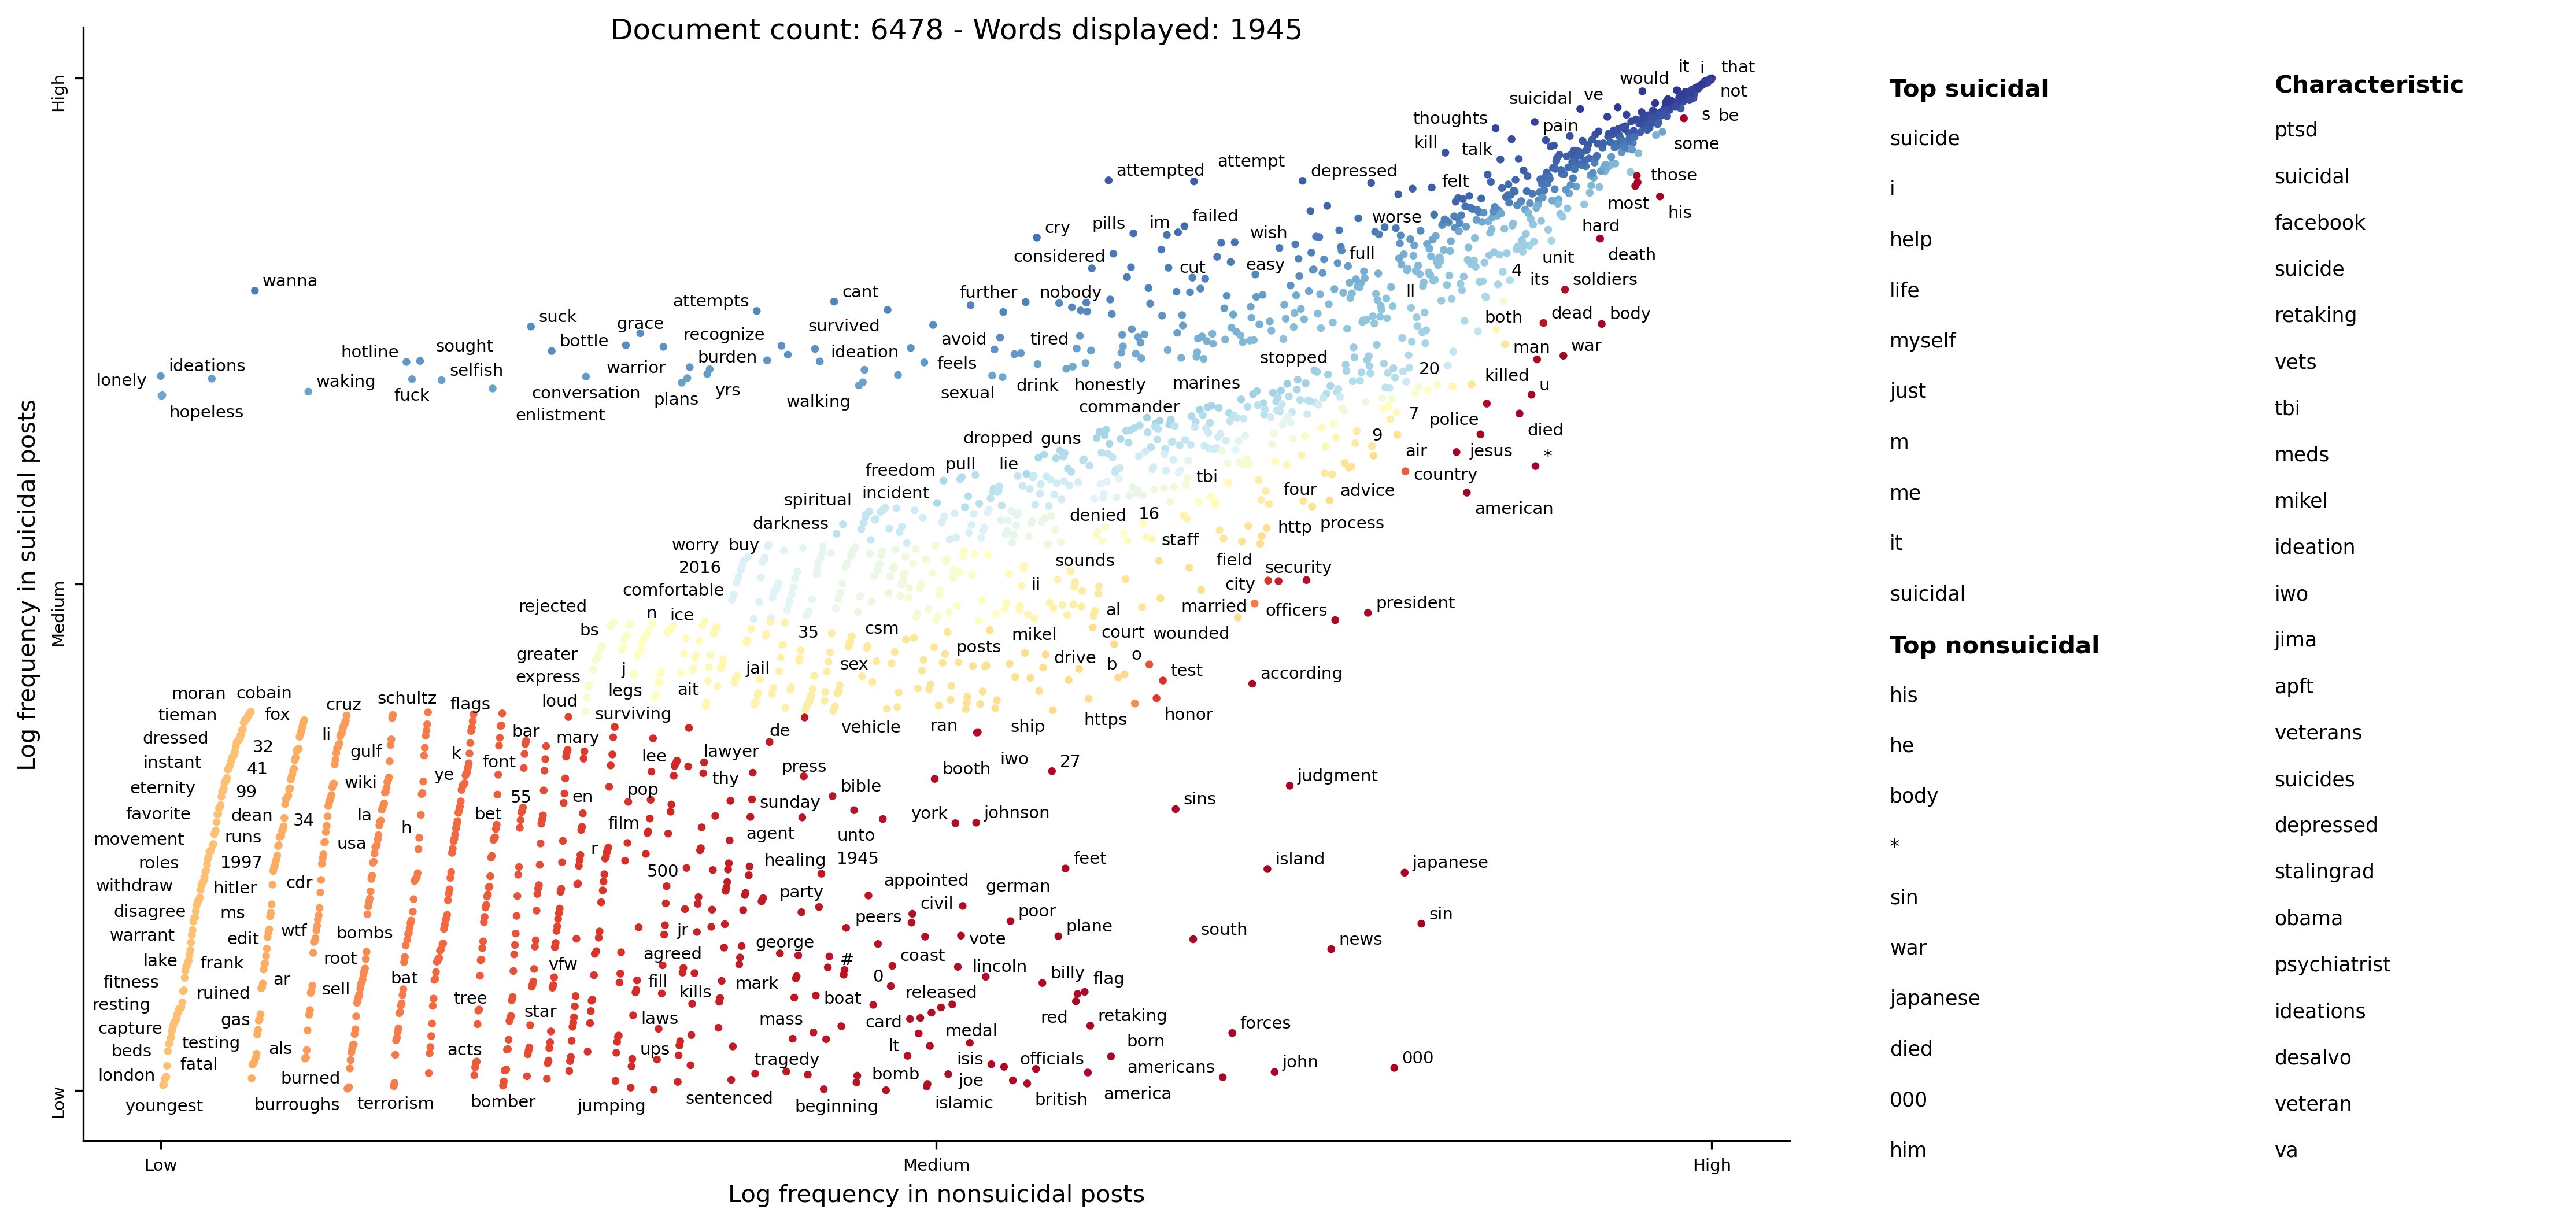

In [124]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

corpus_unigram_clean = corpus_unigram.remove_terms(terms = ['groupforsuicidalactivedutyandforsuicidalveterans'])

html = st.produce_scattertext_explorer(
    corpus_unigram_clean,
    category=category, category_name=category, not_category_name=not_category,
    minimum_term_frequency=minimum_term_frequency, pmi_threshold_coefficient=0,
    width_in_pixels=1000, 
    transform=st.Scalers.percentile_alphabetical,
    # metadata=corpus.get_df()['type'],
    # transform = default is percentile_alphabetical?, #st.Scalers.scale_center_zero_abs, #{dense_rank, st.Scalers.scale_center_zero_abs(vec)}
                                       # https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/Scalers.py#L217
    # scores
    term_scorer=return_method(score_method)
)
open(output_dir+filename+'.html', 'w').write(html)


# just copy it but add return_scatterplot_structure=True to output the structure
scattertext_structure = produce_scattertext_explorer(
    
    # return_corpus(ngram),
    corpus_unigram_clean,
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=minimum_term_frequency,
                                    pmi_threshold_coefficient=0,
                                    transform=st.Scalers.percentile_alphabetical,
                                    # metadata=corpus.get_df()['speaker'],
                                    term_scorer=return_method(score_method),
                                    width_in_pixels=1000,
    x_label = 'Log frequency in '+not_category+' posts',
    y_label = 'Log frequency in '+category+' posts',
    
                                 return_scatterplot_structure=True,
                                                    )



fig = st.produce_scattertext_pyplot(scattertext_structure)
fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)

In [125]:
dispersion = st.Dispersion(return_corpus(ngram))
dispersion_df = dispersion.get_df()
display(dispersion_df)

term_category_scores = return_corpus(ngram).get_metadata_freq_df('')
print(term_category_scores)

/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:59: RuntimeWarning: divide by zero encountered in divide
  self.p = X.multiply(csc_matrix(1. / X.sum(axis=1)))
/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:167: RuntimeWarning: divide by zero encountered in divide
  vfs = vf.multiply(1. / self.s)


,Frequency,Range,SD,VC,Juilland's D,Rosengren's S,DP,DP norm,KL-divergence
that,9383,3304,2.219865,1.532589,9.790578e-01,0.737412,0.333101,0.333101,0.591687
s,3442,1739,1.248843,2.350378,9.610044e-01,0.448021,0.537614,0.537614,1.385873
where,703,578,0.386303,3.559698,9.319086e-01,0.186297,0.790719,0.790719,2.624779
i,28578,4920,6.122436,1.387821,9.883201e-01,0.788692,0.283734,0.283734,0.440138
thought,813,704,0.410379,3.269910,9.379404e-01,0.114366,0.849004,0.849004,3.650048
...,...,...,...,...,...,...,...,...,...
moran,14,1,0.173930,80.479811,2.220446e-16,0.000492,0.999508,0.999508,10.987903
defeo,20,2,0.175682,56.903427,2.929478e-01,0.001049,0.998951,0.998951,9.897391
cobain,14,1,0.173930,80.479811,-2.220446e-16,0.000524,0.999476,0.999476,10.897391
sadat,18,2,0.158114,56.903427,2.928086e-01,0.000893,0.999107,0.999107,10.129848


Empty DataFrame
Columns: [nonsuicidal, suicidal]
Index: []


### Save as figure

NameError: name 'scatterplot_structure' is not defined

In [126]:
[n for n in corpus.get_terms() if n.startswith('groupfor')]

NameError: name 'corpus' is not defined

## Word scores (axes are F-score as a function of term frequency in corpus, color-coded by F-scores)

In [151]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

html = st.produce_fightin_words_explorer(
    corpus_unigram_clean,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

)

open(output_dir+filename+'.html', 'w').write(html)


# just copy it but add return_scatterplot_structure=True to output the structure


TypeError: produce_scattertext_explorer() got an unexpected keyword argument 'to_html'

In [127]:
dispersion = st.Dispersion(corpus_unigram_clean).get_df()
dispersion['Frequency'].describe()

/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:59: RuntimeWarning: divide by zero encountered in divide
  self.p = X.multiply(csc_matrix(1. / X.sum(axis=1)))
/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:167: RuntimeWarning: divide by zero encountered in divide
  vfs = vf.multiply(1. / self.s)


count     1945.000000
mean       290.263239
std       1359.240741
min         14.000000
25%         23.000000
50%         49.000000
75%        147.000000
max      28578.000000
Name: Frequency, dtype: float64

In [313]:
# parsed = np.array([n.text for n in corpus_unigram_clean.get_df()['parse'].values])
# parsed
# print(len(parsed), 'documents')

In [314]:


# tokens = []
# for n in parsed:
#     try: tokens.append(n.replace('\n',' ').replace('\t', ' '.split(' '))
#     except: 
#         print(n)
# tokens = np.unique([n for i in tokens for n in i])
# counts_df = pd.DataFrame(counts, index = ['counts']).T
# counts_df[counts_df['counts']>=2] #none, because I need to parse tokens correctly removing punctuation, lower case
# counts_df


In [158]:
# scattertext_structure._visualization_data.word_dict["docs"]["texts"]
scattertext_structure._visualization_data.word_dict['docs']['texts']


{'categories': ['nonsuicidal', 'suicidal'],
 'labels': array([0, 0, 1, ..., 0, 0, 0]),
 'texts': ["That's kinda where I thought it would be, had not seen those posts",
  'I am the coach of my- Group for Police Officers: Suicidal/Depressed/PTSD; on Facebook.  All Police Officers, Police Dependents, and Police supporters are warmly welcome to join my group.',
  'I pray every night for God to end my suffering, but maybe I have to end it myself.',
  "Good advice. You/we are the ones who are different. THEY are trying to understand-and WANT TO!! Don't give up on them, and they won't give up on you. Get some help-people WANT to help you. And doing it alone only makes it harder.",
  'That\'s what I was thinking. I didn\'t even make it through the beginning of the story. You never yell "no" in a loud vehicle because it sounds just like "go". JM\'s are organic to the unit so. Most JM\'s don\'t come from combat units, they come from the jumping unit. Nobody cares if a JM is a female, it\'s a job

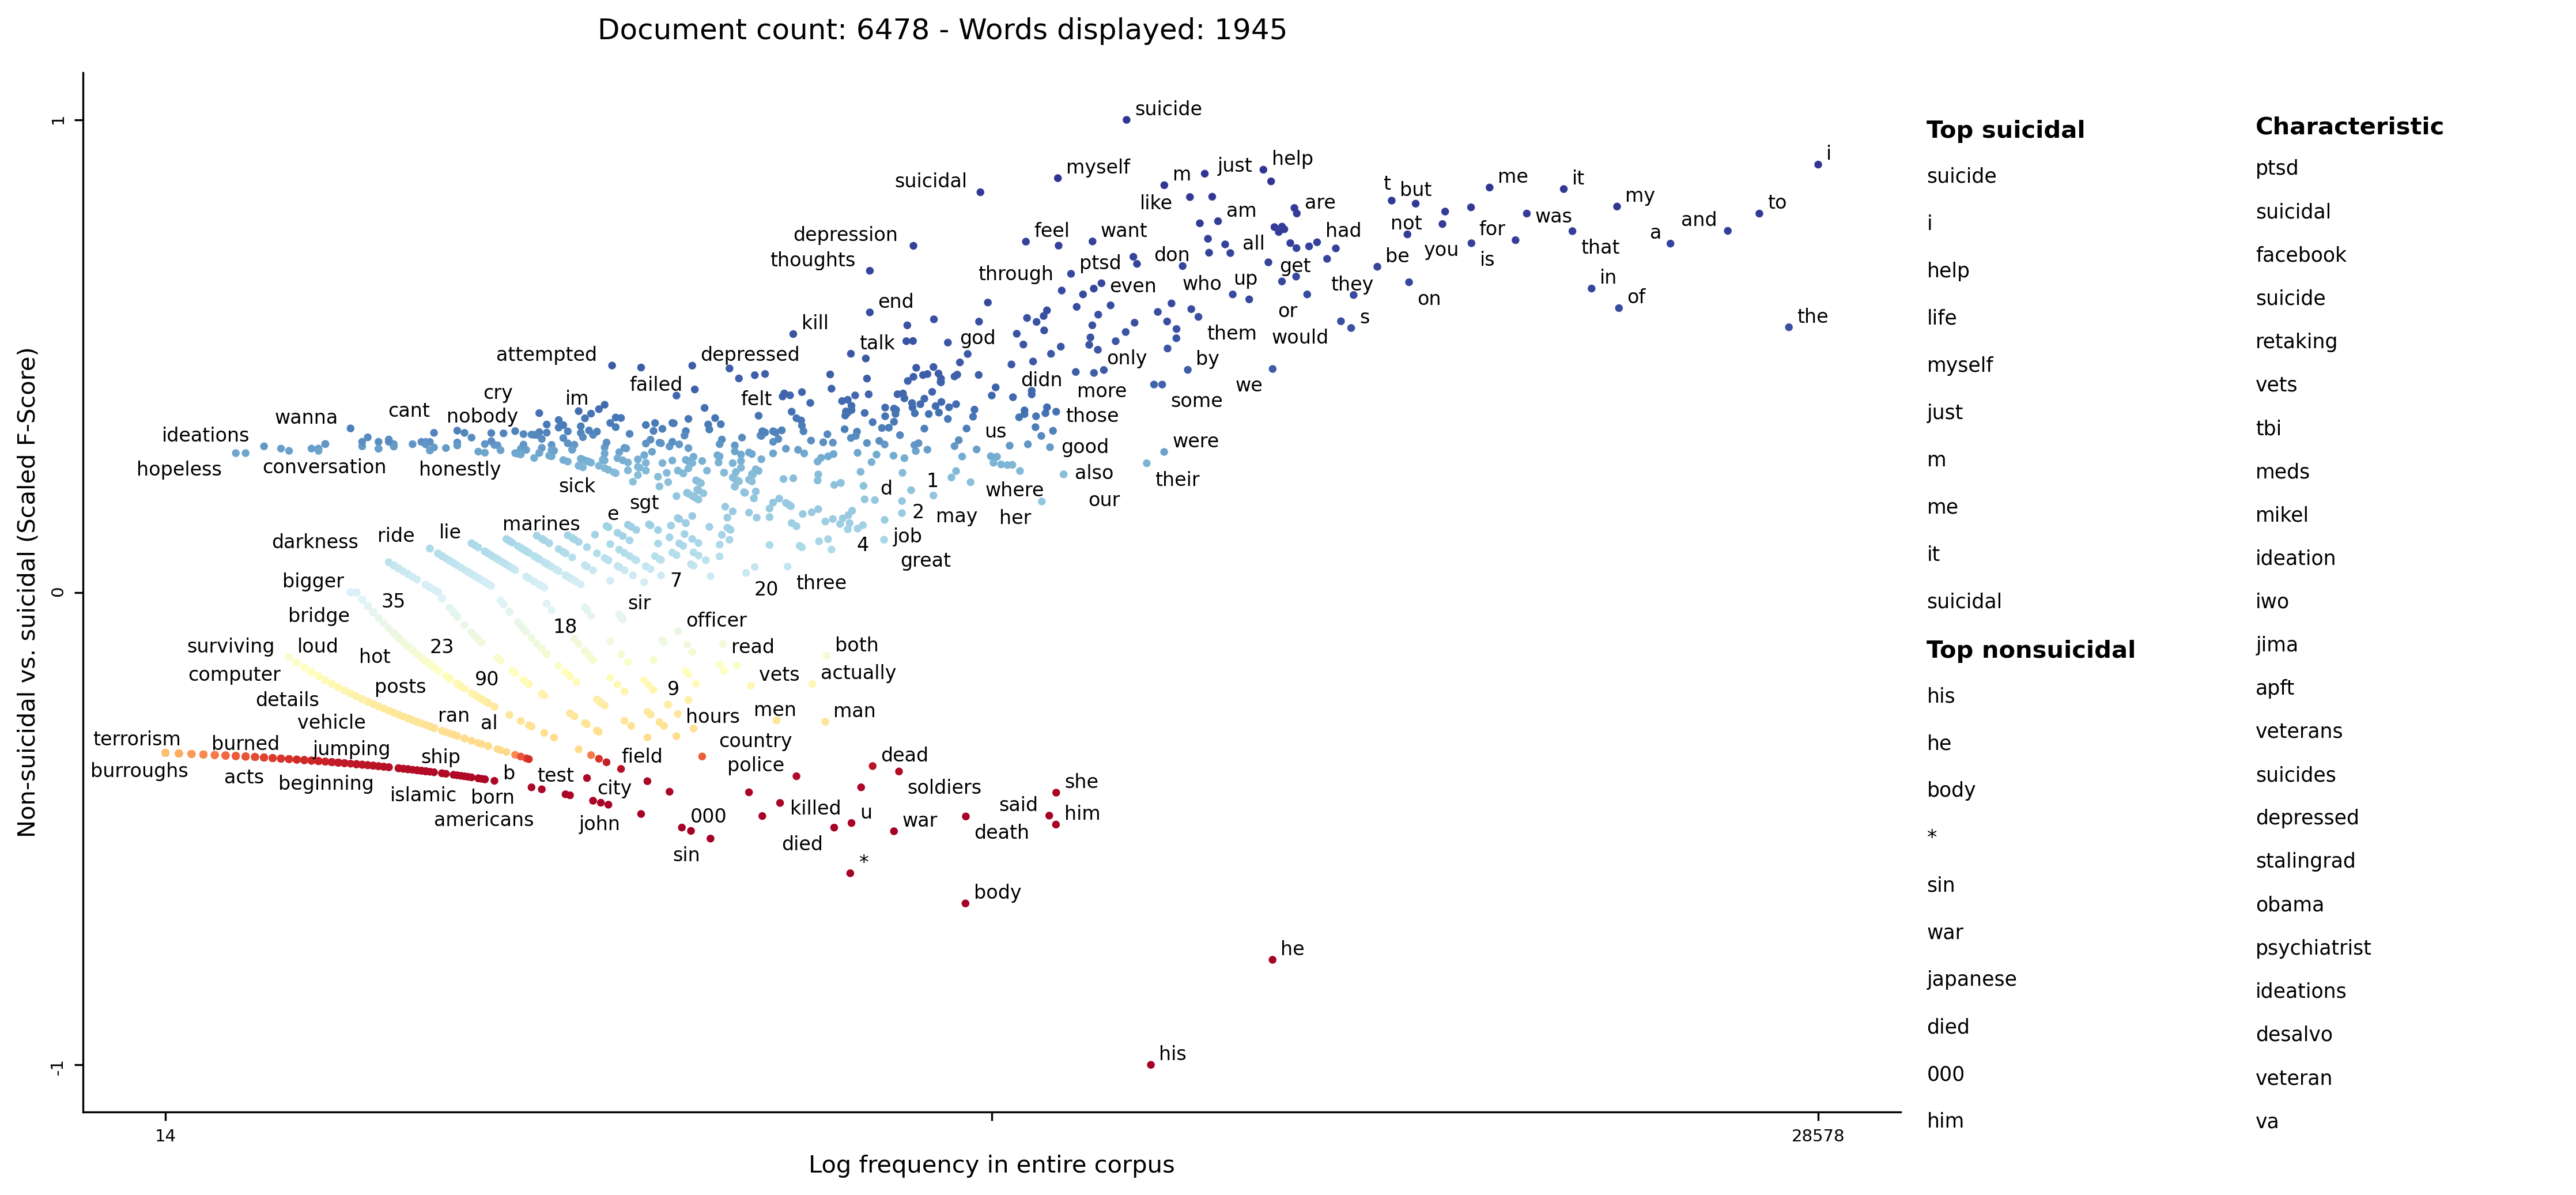

In [128]:

scattertext_structure = st.produce_fightin_words_explorer(
corpus_unigram_clean,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

    
    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)
# Change plotting params add '_' at the beginning:
scattertext_structure._x_label = 'Log frequency in entire corpus'
scattertext_structure._y_label = 'Non-suicidal vs. suicidal (Scaled F-Score)'

# Change plotting params: I think it requires 3 values
log_freq_distr = dispersion['Frequency'].values
min_freq = int(np.min(log_freq_distr))
max_freq = int(np.max(log_freq_distr))
scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=300)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
plt.show()
fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)


### List sentences with top words


In [149]:
# Warning: this is ont the order of the final plot (probably due to percentile_alphabetical or the exact method for f-score?
term_freq_df = corpus_unigram_clean.get_term_freq_df()
term_freq_df[f'{category} score'] = corpus_unigram_clean.get_scaled_f_scores(category)
term_freq_df.sort_values('suicidal score')[::-1]

,nonsuicidal freq,suicidal freq,suicidal score
term,,,
suicide,925,318,1.000000
i,24639,3939,0.995732
me,5645,801,0.985352
it,7908,1114,0.984654
help,1986,326,0.980778
...,...,...,...
him,853,49,0.223924
their,1271,91,0.165623
were,1374,100,0.151279


In [106]:
n=100

top_words_category = list(term_freq_df.sort_values(by=f'{category} score', ascending=False).index[:n])
top_words_category_score = corpus_unigram.get_scaled_f_scores(category)[:n]
# top_words_not_category = list(term_freq_df.sort_values(by=f'{category} score', ascending=False).index[::-1][:n])
# top_words_not_category_score = corpus_unigram.get_scaled_f_scores(category)[::-1][:n]

df_i = corpus_unigram.get_df()
df_category = df_i[df_i[group_col_name]==category]
df_not_category = df_i[df_i[group_col_name]==not_category]

import re


def return_sample_word_in_docs(df, words, text_col_name = 'content', sample_n = 5):
    words_to_docs = {}
    words_to_docs_windows = {}
    for word in words:
        if word == 'i':
            word = 'I'
        elif word == 'm':
            word = "I'm"
        # elif word  == 
        
        # search_for = word # '|'.join(search_for could add specific: ' '+word+' ', ' '+word+'.', ' '+word+'?'
        docs_with_word = df[df[text_col_name].str.contains(word)][text_col_name].sample(n=sample_n)
        assert docs_with_word.shape[0] == sample_n
        docs_with_word = docs_with_word.values
        docs_with_word = [n.replace('\n', ' ') for n in docs_with_word]
        words_to_docs[word] = '\n'.join(docs_with_word)
        
        regex_str = r'(?:\b\S+\s*){,7}\b'+ re.escape(word) +r'\b(?:\s*\S+\s*?){,7}'
        
        
        # from each post, return n words before and after target word.
        # try: docs_with_word_windows = [re.findall(regex_str, doc)[0] for doc in docs_with_word]
        # except:
        #     print(docs_with_word)
        #     break
        
        docs_with_word_windows = []
        
        for doc in docs_with_word:
            try: 
                found = re.findall(regex_str, doc)[0] # Will take the first one if multiple are found
                docs_with_word_windows.append(found)
            except: pass
            

        # docs_with_word_windows = [n for i in docs_with_word_windows for n in i] #flatten
        words_to_docs_windows[word] = '\n'.join(docs_with_word_windows)
    return words_to_docs, words_to_docs_windows
        

# docs_not_category_d = return_sample_word_in_docs(df_not_category, top_words_not_category, sample = 5)


In [107]:
# # [re.findall(regex_str, doc)[0] for doc in a]
# regex_str = r'(?:\b\S+\s*){,7}\b'+ re.escape(word) +r'\b(?:\s*\S+*?){,7}'
# re.findall(regex_str, a[3])

In [108]:
# word = 'suicide'

# docs_with_word = ['I would be surprised if "thinking about suicide" is not much higher than 14%. THinking about it doesn\'t mean you are going to do it. I have thought about it, but am way too chicken to ever do it.', ", I considered suicide many times in my life.  I was molested and threatened with death by the time I was 10 years old which may have had some bearing on my depression.  I took many foolish chances as a young man but by the grace of God I survived with mere bruises and breaks.  I had bouts with clinical depression defined as making serious plans to end my life and being prepared to execute those plans.  I was clinically depressed before I recognized my need for a savior in 1987 and repented and became a believer in my Lord and savior Jesus the Christ.  I have been clinically depressed after that point. While the depth of depression is the same before and after Christ the sense of hopelessness I experienced prior to my salvation was not.   After my first wife served no-contact orders on my while I was going through a recent diagnosis of heart disease, I was severely depressed and made a plan to drive off a cliff somewhere.  I calmly began to execute my plan when the Lord prompted me to trust Him, turn around and go home. The level of depression was the same as before but I had hope.  Hope in Christ is not a maybe it is the most surest thing in existence. I have been through many unbelievable challenging situations since my last confrontation with suicidal thoughts in the 1990's. My hope in Christ and my absolute faith in God helps me each day. God sustains me. They that endure to the end the same shall be saved.   ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,", 'I feel like the only way out of my shitty situation is suicide', "Have you considered suicide?  What helped you choose life? Have you ever gotten to a point in your life when you seriously considered, or possibly attempted suicide?  If so, what was it that caused to to choose to live?  Or did someone rescue you?  How did you overcome that level of despair?   As a 24 yr old, I attempted suicide by trying to run my car head on into an oncoming log truck.  At the last second I got scared and chose life, driving off into the ditch.  My faith, my best friend, and my professional mentors saved my life.  I learned, with God's strength, that life can be handled, no matter how tough.  I am 50 now and life hasn't been a bed of roses.  But no matter how long or dark the night, the sun always comes up for me.  What about you?", 'Every time i hear that a Veteran or Active Duty service member commits suicide due to PTSD i cringe and become sad. Because it hurts to know they could not go on. I was there a year ago and my wife came in just in time.']
# regex_str = r'(?:\b\S+\s*){,7}\b'+ re.escape(word) +r'\b(?:\s*\S+\s*?){,7}'
        

# # from each post, return n words before and after target word.
# docs_with_word_windows = [re.findall(regex_str, doc)[0] for doc in docs_with_word]
# docs_with_word_windows

In [109]:
# docs_with_word_windows = [re.findall(regex_str, doc)[0] for doc in docs_with_word]


In [112]:
top_words_category

['suicide',
 'i',
 'me',
 'it',
 'help',
 'but',
 't',
 'my',
 'have',
 'just',
 'with',
 'was',
 'to',
 'you',
 'and',
 'that',
 'not',
 'out',
 'life',
 'for',
 'is',
 'are',
 'a',
 'can',
 'as',
 'at',
 'there',
 'so',
 'all',
 'be',
 'what',
 'had',
 'm',
 'on',
 'in',
 'when',
 'this',
 'been',
 'if',
 'am',
 'of',
 'they',
 'like',
 'the',
 'myself',
 'do',
 'get',
 'about',
 'know',
 'no',
 'from',
 'or',
 'up',
 'would',
 's',
 'suicidal',
 'one',
 'don',
 'who',
 'now',
 'want',
 'years',
 've',
 'time',
 'them',
 'because',
 'feel',
 'we',
 'even',
 'people',
 'ptsd',
 'va',
 'an',
 'depression',
 'got',
 'did',
 'how',
 'through',
 'after',
 'still',
 'will',
 'go',
 'going',
 'back',
 'by',
 'then',
 'thoughts',
 'has',
 'take',
 'many',
 'only',
 'better',
 'never',
 'could',
 'things',
 'way',
 'some',
 'military',
 'your',
 'being']

In [110]:
sample_n = 5
words_to_docs_category_d, words_to_docs_windows_category_d  = return_sample_word_in_docs(df_category, top_words_category, sample_n = sample_n)
word_examples = pd.DataFrame(words_to_docs_windows_category_d, index = ['Examples']).T
word_examples.to_csv(output_dir+filename+f'_examples_top-{n}-words_{n}-examples_{sample_n}.csv')
word_examples

,Examples
suicide,so much pain that I actually considered suicid...
I,re enlistment possible Giving a back story I ...
me,FINALLY found a decent therapist/LCSW to help ...
it,What makes YOU so RESILIENT?? You made it! Yo...
help,a good someone to help you work out that which...
...,...
way,came to 1stCivDiv.. I STRUGGLED in every way. ...
some,circumstances. I have known many suicides and ...
military,a priest to speak to. During my military servi...
your,"What is your greatest wish?"" with ""Not to wake..."


In [111]:
sample_n = 2
words_to_docs_category_d, words_to_docs_windows_category_d  = return_sample_word_in_docs(df_category, top_words_category, sample_n = sample_n)
word_examples = pd.DataFrame(words_to_docs_windows_category_d, index = ['Examples']).T
word_examples.to_csv(output_dir+filename+f'_examples_top-{n}-words_{n}-examples_{sample_n}.csv')
word_examples

,Examples
suicide,help I most likely would have committed suicid...
I,i deal with episodes is going fishing. I might...
me,"help"", unless somebody could help me do it. F..."
it,"PTSD, unemployment are all such BIG problems i..."
help,GOD almighty I was able to get help/treatment ...
...,...
way,who out ranked her and the only way i could do...
some,
military,early and sexual assault prior to my military ...
your,pride aside to make that step. While your post...


In [281]:
# n = 15

# for word in top_words[:n]:
#     print(words_to_docs_windows_category_d.get(word))

In [185]:
len(scattertext_structure._visualization_data.word_dict["data"])

1945

## Word scores (axes are weighted log odds ratio as a function of term frequency in corpus, color-coded by weighted log odds ratio)


### Log-Odds-Ratio with Informative Dirichlet Prior Z-Score
### Prefered, currently very popular in NLP and CSS literature, flaws exist
### Note: this formulation is modified slightly from Monroe et al. 2008.

We know, intuitively, words which which are used very frequently require much more evidence to be significantly associated with a class than less frequent words.  For example, words like "best" and "entertaining" in the above example should be scored lower than "and" and "of".  

The approach developed by Monroe et. al is to more aggressively smooth terms based on their frequency in a background corpus.

The downside is of this approach is that obtaining a background corpus may be difficult. Lists of background term frequencies, especially for 2+grams, can be very large and unwieldy. Moreover, term frequency lists can become outdated very quickly, especially wrt to politics, pop culture, and technology.

We construct two vectors of background term counts for each category, $\alpha_a$ and $\alpha_b$.  The priors are based on a background set of word frequencies, referred to as $y_{c}$  These are ideally in the same domain as the documents being studied, although could come from a general list of word frequencies.  The background counts are normalized to the size of their respective categories. The hyperparameter $\sigma$ scales the background counts to a multiple of their category size. In other words, as $\sigma$ increases, the regularization increases, and the odds ratio tends more toward zero.

The $\sigma$ I've found most useful is 10, which I include in Scattertext.

$$ \alpha_a = \sigma \cdot n_a \cdot \frac{y_{ci}}{n_c} $$

$$ \alpha_b = \sigma \cdot n_b \cdot \frac{y_{ci}}{n_c} $$


The $\alpha$s can then be used analogously to find the Z-Score of the LOR.

$$ \mbox{LOR}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \log \frac{y_{ai} + \alpha_a}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} - \log \frac{y_{bi} + \alpha_b}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

$$ \mbox{LOR-SE}(\mbox{term}_i, \mbox{category}_a, \mbox{category}_b) = \frac{1}{y_{ai} + \alpha_a} + \frac{1}{n_{a} + \alpha_a \cdot |y| - y_{ai} - \alpha_a} + \frac{1}{y_{bi} + \alpha_b}+ \frac{1}{n_{b} + \alpha_b \cdot |y| - y_{bi} - \alpha_b} $$

Monroe et al. used a different approach to finding $\alpha$, scaling the sum of the peusdocounts to the mean number of words in a document.

$$ \alpha_a = \alpha_b = \overline{|d_{y}|} \frac{y_{ci}}{\sum n_{c}} $$

Jurafsky et al. suggested using raw background corpus counts as $\alpha$.

$$ \alpha_a = \alpha_b = y_c $$

In the following example, we use the plot description as a background corpus using the first method.

* Dan Jurafsky, Victor Chahuneau, Bryan Routledge, and Noah Smith. Narrative framing of consumer sentiment in online restaurant reviews. First Monday. 2014.

In [12]:
priors_unigram = (st.PriorFactory(corpus_unigram, 
                  category=category, 
                  not_categories=[not_category],
                  starting_count=0.01)
  .use_neutral_categories()
  .get_priors())

NameError: name 'corpus_unigram' is not defined

In [316]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'odds_ratio' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

html = st.produce_fightin_words_explorer(
    corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_unigram, 10, 'class-size'),   # also try: st.LogOddsRatioInformativeDirichletPrior(priors, 1, 'corpus-size')
    # metadata = rdf['movie_name'],
    grey_threshold=0.1
)

open(output_dir+filename+'.html', 'w').write(html)


# just copy it but add return_scatterplot_structure=True to output the structure


4766313

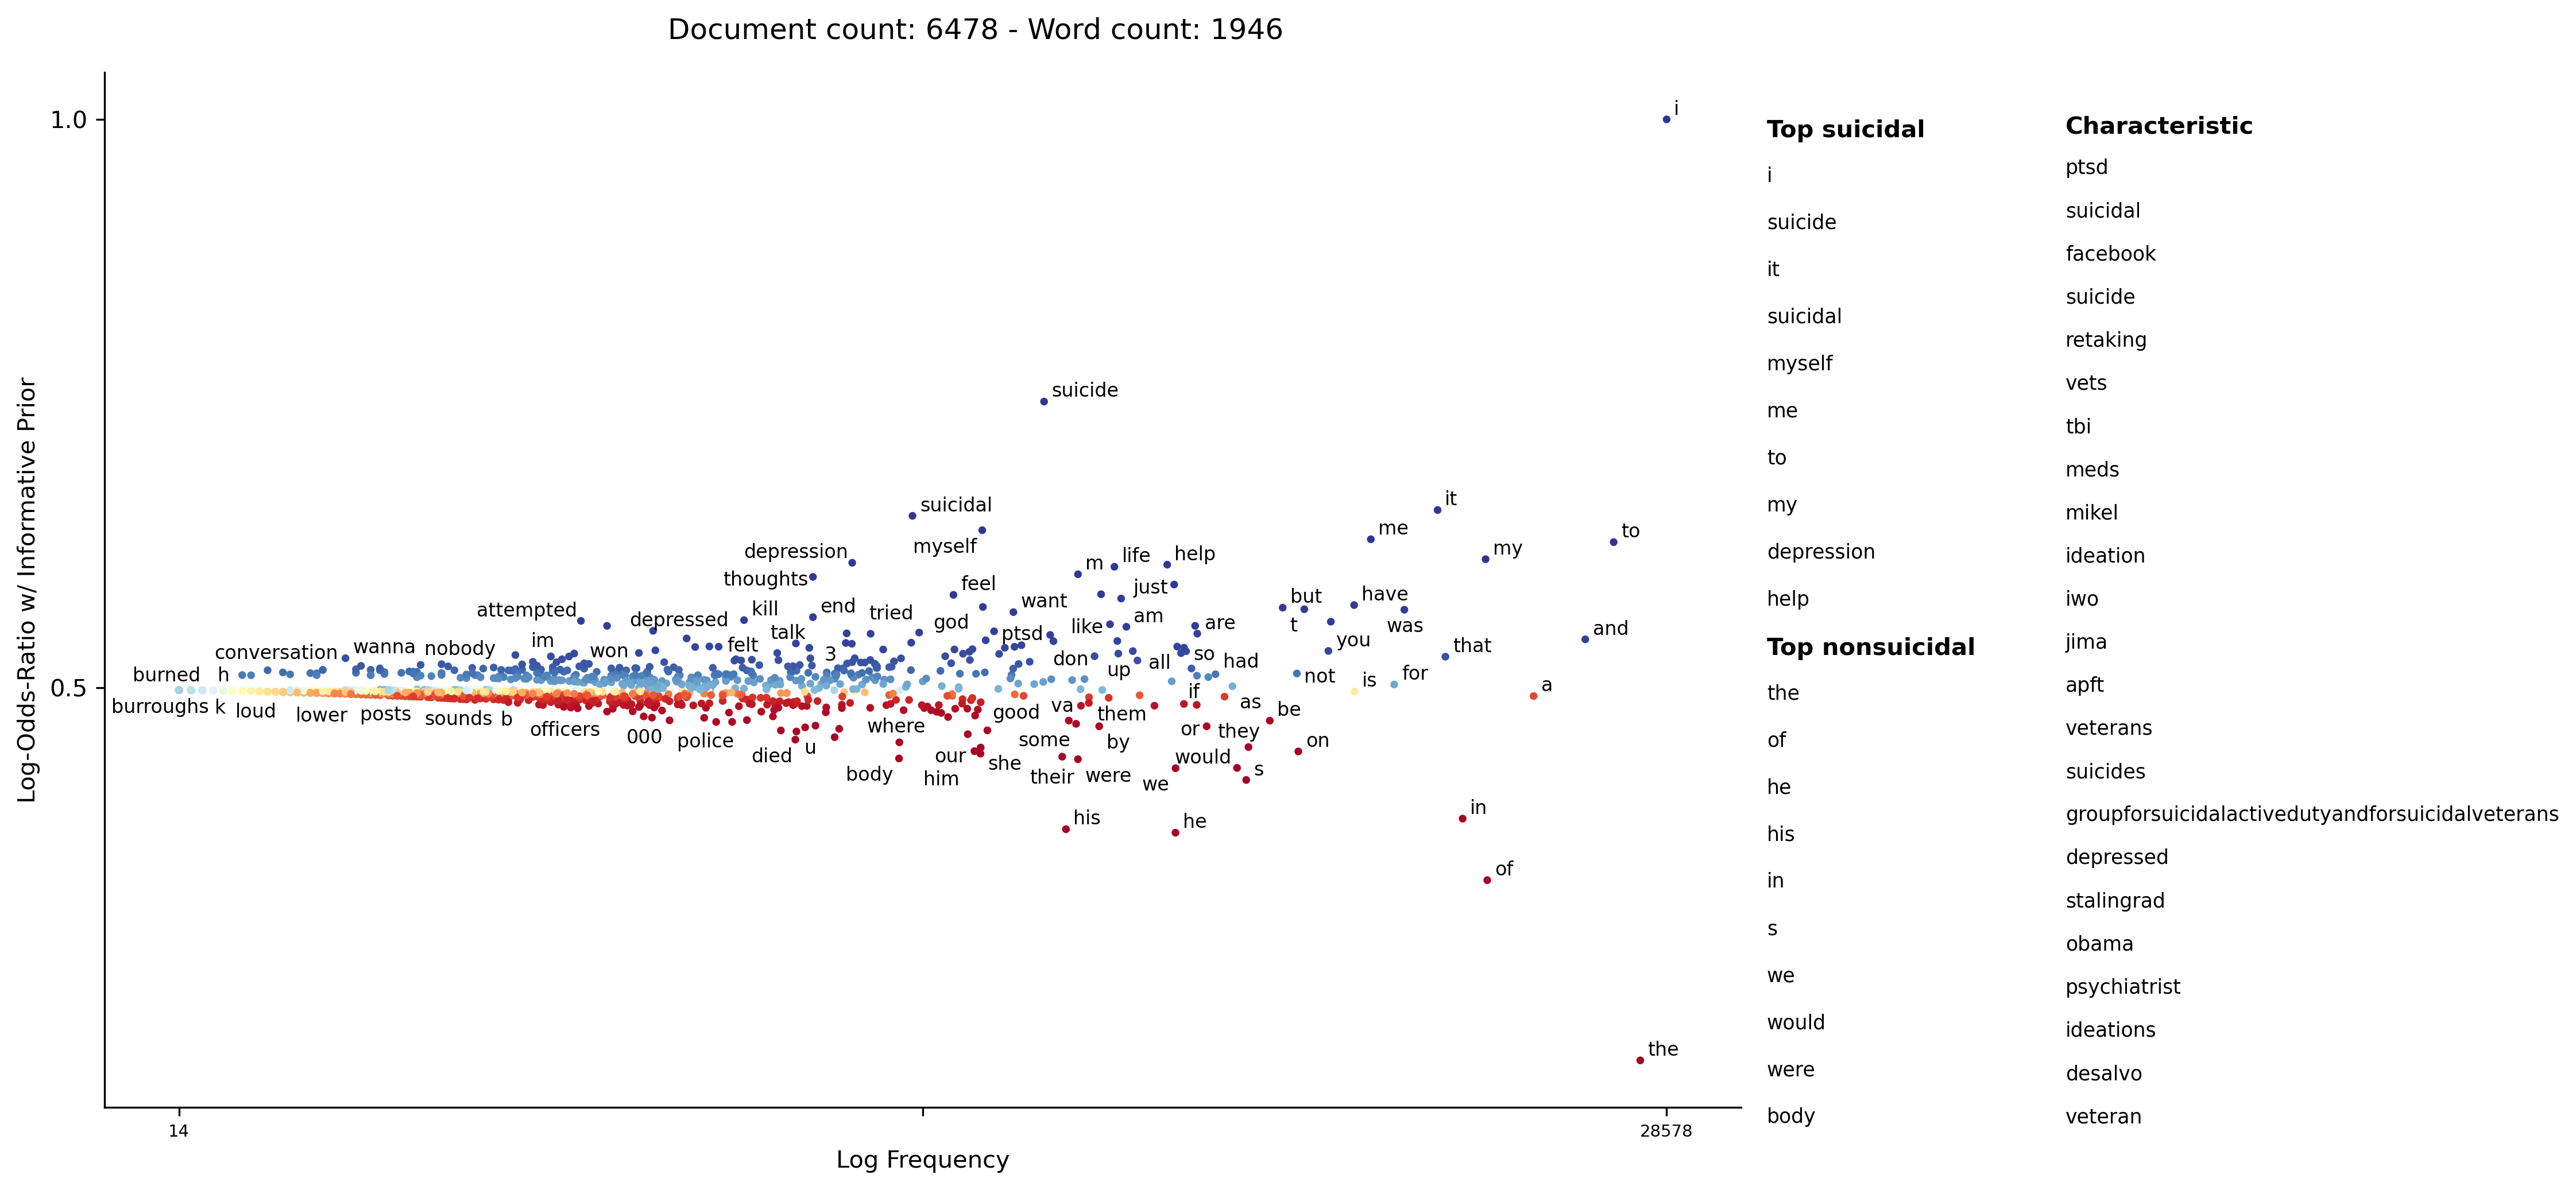

In [317]:
ngram = 'word' # {'word', 'phrases'}
score_method = 'odds_ratio' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


scattertext_structure = st.produce_fightin_words_explorer(
corpus_unigram,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_unigram, 10, 'class-size'),   # also try: st.LogOddsRatioInformativeDirichletPrior(priors, 1, 'corpus-size')
    # metadata = rdf['movie_name'],
    grey_threshold=0.1,

    
    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)
# Change plotting params add '_' at the beginning:
# scattertext_structure._x_label = 'Log frequency in entire corpus'
# scattertext_structure._y_label = 'Non-suicidal vs. suicidal (Scaled F-Score)'

# Change plotting params: I think it requires 3 values
log_freq_distr = dispersion['Frequency'].values
min_freq = int(np.min(log_freq_distr))
max_freq = int(np.max(log_freq_distr))
scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
# scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=300)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
plt.show()
fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)


# Phrase scores

Phrasemachine from AbeHandler (Handler et al. 2016) uses regular expressions over sequences of part-of-speech tags to identify noun phrases. This has the advantage over using spaCy's NP-chunking in that it tends to isolote meaningful, large noun phases which are free of appositives.


## Phrase scores (axes are term frequency in each group, color-coded by F-scores)

dense-rank difference: a score which is used in most of the two-category contrastive plots here

maximum category-specific score: most prominent phrases in each category, regardless of the prominence in the other category

Fscore: st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),

In [21]:
dispersion_phrases = st.Dispersion(corpus_phrases).get_df()
dispersion_phrases

/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:59: RuntimeWarning: divide by zero encountered in divide
  self.p = X.multiply(csc_matrix(1. / X.sum(axis=1)))
/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/dispersion/dispersion.py:167: RuntimeWarning: divide by zero encountered in divide
  vfs = vf.multiply(1. / self.s)


,Frequency,Range,SD,VC,Juilland's D,Rosengren's S,DP,DP norm,KL-divergence
group for police,28,28,0.065602,15.177521,7.488407e-01,0.045784,0.947801,0.947801,4.679004
group for police officers,28,28,0.065602,15.177521,7.488407e-01,0.045784,0.947801,0.947801,4.679004
police officers,51,40,0.105863,13.446649,7.663229e-01,0.051824,0.936220,0.936220,4.622832
suicidal people,8,6,0.043022,34.837121,4.887762e-01,0.001757,0.997902,0.997902,9.423533
sexual assault,25,18,0.079462,20.590211,7.173147e-01,0.005420,0.993958,0.993958,7.693684
...,...,...,...,...,...,...,...,...,...
2b re,2,1,0.024847,80.479811,-2.220446e-16,0.000671,0.999329,0.999329,10.540612
2b re code,2,1,0.024847,80.479811,-2.220446e-16,0.000671,0.999329,0.999329,10.540612
sunny days,3,1,0.037271,80.479811,-2.220446e-16,0.000671,0.999329,0.999329,10.540612
lonely times,3,1,0.037271,80.479811,-2.220446e-16,0.000671,0.999329,0.999329,10.540612


In [342]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

minimum_term_frequency=10
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


html = produce_scattertext_explorer(return_corpus(ngram),
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=minimum_term_frequency,
                                    pmi_threshold_coefficient=0,
                                    transform=st.Scalers.percentile_alphabetical,
                                        # grey_threshold=0.1,

                                    # metadata=corpus.get_df()['speaker'],
                                    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
                                    width_in_pixels=1000)

open(output_dir+f'{filename}.html', 'w').write(html)


/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/termscoring/ScaledFScore.py:303: RuntimeWarning: invalid value encountered in divide
  recall = cat_word_counts * 1. / cat_word_counts.sum()


4258934

In [345]:
return_method(score_method)

In [23]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

minimum_term_frequency=10
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

# same as above with     return_scatterplot_structure=True
scattertext_structure = st.produce_scattertext_explorer(
    corpus_phrases,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    # transform=dense_rank,
    minimum_term_frequency=0,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    # grey_threshold=0,

    
    # y_axis_values = [-1,0,1],
    return_scatterplot_structure=True
)
# Change plotting params add '_' at the beginning:
# scattertext_structure._x_label = 'Log frequency in entire corpus'
# scattertext_structure._y_label = 'Non-suicidal vs. suicidal (Scaled F-Score)'

# Change plotting params: I think it requires 3 values
# log_freq_distr = dispersion['Frequency'].values
# min_freq = int(np.min(log_freq_distr))
# max_freq = int(np.max(log_freq_distr))
# scattertext_structure._x_axis_labels=[min_freq, '',max_freq]
# https://github.com/JasonKessler/scattertext/blob/b41e3a875faf6dd886e49e524345202432db1b21/scattertext/viz/PyPlotFromScattertextStructure.py#L149
# scattertext_structure._y_axis_labels=[-1,0,1]#[f'{not_category} (-1)','0',f'{category} (1)']



fig = st.produce_scattertext_pyplot(scattertext_structure, textsize = 8, dpi=300)
# plt.xticks(ticks = [-1,0,1],labels=[-1,0,1])
plt.tight_layout()
plt.show()
# fig.savefig(output_dir+f'{filename}.tiff', format='tiff', dpi = 150)
# fig.savefig(output_dir+f'{filename}.png', format='png', dpi = 150)




NoWordMeetsTermFrequencyRequirementsError: 

## Phrase scores (axes are F-score as a function of term frequency in corpus, color-coded by F-scores)

,nonsuicidal freq,suicidal freq,suicidal score
term,,,
many suicides,0,7,1.000000e+00
3 chapter,0,6,9.938823e-01
someone with ptsd,0,5,9.738098e-01
grace of god,3,11,9.602425e-01
comma for 3 days,1,5,9.452394e-01
...,...,...,...
world war ii,40,0,6.380726e-06
war ii,41,0,3.563100e-06
world war,41,0,3.563100e-06


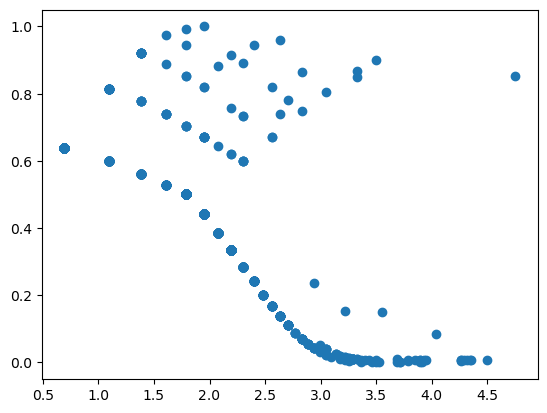

In [142]:
phrase_freq_df = corpus_phrases.get_term_freq_df()
phrase_freq_df[f'{category} score'] = corpus_phrases.get_scaled_f_scores(category)
phrase_freq_df = phrase_freq_df.sort_values('suicidal score')[::-1]
display(phrase_freq_df)
plt.scatter(np.log(phrase_freq_df['nonsuicidal freq']+phrase_freq_df['suicidal freq']), phrase_freq_df['suicidal score'])



In [335]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'score' # {'freq', 'score'}

minimum_term_frequency=0
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'


html = st.produce_fightin_words_explorer(
    # return_corpus(ngram),
    corpus_phrases,
    filter_unigrams = False,
    category=category,
    category_name=category,
    not_category_name=not_category,
    not_categories=[not_category],
    neutral_categories=[],
    transform=st.Scalers.percentile_alphabetical,
    minimum_term_frequency=minimum_term_frequency,
    term_scorer=st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
    # metadata = rdf['movie_name'],
    # grey_threshold=0.1
)

open(output_dir+f'{filename}.html', 'w').write(html)




NoWordMeetsTermFrequencyRequirementsError: 

In [328]:


# html = st.produce_frequency_explorer(
#     corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
#     category=category,
# category_name=category,
# not_category_name=not_category,
#     not_categories=[not_category],
#     term_scorer=st.ScaledFScorePresets(beta=1, one_to_neg_one=True),
#     # metadata=rdf['movie_name'],
#     grey_threshold=0
# )

# open(output_dir+f'{filename}.html', 'w').write(html)


## Phrase scores (axes are weighted log odds ratio as a function of term frequency in corpus, color-coded by weighted log odds ratio)

In [16]:
priors_phrases = (st.PriorFactory(corpus_phrases, 
                  category=category, 
                  not_categories=[not_category],
                  starting_count=0.01)
  .use_neutral_categories()
  .get_priors())

In [19]:
ngram = 'phrases' # {'word', 'phrases'}
score_method = 'fscore' # {'fscore','rank_difference', 'dense_rank', 'odds_ratio'}
axes = 'freq' # {'freq', 'score'}

minimum_term_frequency=0
filename = f'{ngram}_method-{score_method}_axes-{axes}_compaction-{compaction}-freq-{minimum_term_frequency}'

html = produce_scattertext_explorer(corpus_phrases,
                                    category=category,
                                    category_name=category,
                                    not_category_name=not_category,
                                    minimum_term_frequency=3,
                                    pmi_threshold_coefficient=0,
                                    transform=dense_rank,
                                    # metadata=corpus.get_df()['speaker'],
                                    # term_scorer=RankDifference(),
                                    # term_scorer= st.ScaledFScorePresetsNeg1To1(beta=1, scaler_algo='normcdf'),
                                    term_scorer=st.LogOddsRatioInformativeDirichletPrior(priors_phrases, 10, 'class-size'),    
                                    width_in_pixels=1000)

open(output_dir+f'{filename}.html', 'w').write(html)





/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/termscoring/ScaledFScore.py:303: RuntimeWarning: invalid value encountered in divide
  recall = cat_word_counts * 1. / cat_word_counts.sum()


4467819

## Phrase scores using a different phrase-detection method textrank

In [ ]:


# Alternative phrase detection method 

%%time 

nlp = spacy.load("en_core_web_sm")


nlp.add_pipe("textrank", last=True)

df = train.assign(
    parse=lambda df: df[text_col_name].apply(nlp),
    # party=lambda df: df[group_col_name].apply({'democrat': 'Democratic', 'republican': 'Republican'}.get)
)
corpus = st.CorpusFromParsedDocuments(
    df,
    category_col=group_col_name,
    parsed_col='parse',
    feats_from_spacy_doc=st.PyTextRankPhrases()
).build(
).compact(
    AssociationCompactor(2000, use_non_text_features=True) # number of phrases displayed in the chart

)
# The phrases generated will be treated like non-textual features since their document scores will not correspond to word counts.


In [61]:
term_ranks = np.argsort(np.argsort(-term_category_scores, axis=0), axis=0) + 1
metadata_descriptions = {
    term: '<br/>' + '<br/>'.join(
        '<b>%s</b> TextRank score rank: %s/%s' % (cat, term_ranks.loc[term, cat], corpus.get_num_metadata())
        for cat in corpus.get_categories())
    for term in corpus.get_metadata()
}
category_specific_prominence = term_category_scores.apply(
    # lambda r: r.Democratic if r.Democratic > r.Republican else -r.Republican,
    lambda r: r['Suicidal'] if r['Suicidal'] > r['Non-suicidal'] else -r['Non-suicidal'],
    axis=1
)

In [67]:
html = produce_scattertext_explorer(
    corpus,
    category=category,
    not_category_name=not_category,
    minimum_term_frequency=2,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=dense_rank,
    # metadata=corpus.get_df()['speaker'],
    scores=category_specific_prominence,
    sort_by_dist=False,
    use_non_text_features=True,
    topic_model_term_lists={term: [term] for term in corpus.get_metadata()},
    topic_model_preview_size=0,
    metadata_descriptions=metadata_descriptions,
    use_full_doc=True
)
open(output_dir+'explorer_collocations.html', 'w').write(html)

5640118

In [68]:
html = produce_scattertext_explorer(
    corpus,
    category=category,
    not_category_name=not_category,
    minimum_term_frequency=2,
    pmi_threshold_coefficient=0,
    width_in_pixels=1000,
    transform=dense_rank,
    use_non_text_features=True,
    # metadata=corpus.get_df()['speaker'],
    term_scorer=RankDifference(),
    sort_by_dist=False,
    topic_model_term_lists={term: [term] for term in corpus.get_metadata()},
    topic_model_preview_size=0, 
    metadata_descriptions=metadata_descriptions,
    use_full_doc=True
)
open(output_dir+'explorer_collocations_2.html', 'w').write(html)

5640406

# How do the two types of post talk about suicide?

In this configuration of Scattertext, words are colored by their similarity to a query phrase.
This is done using spaCy-provided GloVe word vectors (trained on the Common Crawl corpus). The cosine distance between vectors is used, with mean vectors used for phrases.

The calculation of the most similar terms associated with each category is a simple heuristic. First, sets of terms closely associated with a category are found. Second, these terms are ranked based on their similarity to the query, and the top rank terms are displayed to the right of the scatterplot.

A term is considered associated if its p-value is less than 0.05. P-values are determined using Monroe et al. (2008)'s difference in the weighted log-odds-ratios with an uninformative Dirichlet prior. This is the only model-based method discussed in Monroe et al. that does not rely on a large, in-domain background corpus. Since we are scoring bigrams in addition to the unigrams scored by Monroe, the size of the corpus would have to be larger to have high enough bigram counts for proper penalization. This function relies the Dirichlet distribution's parameter alpha, a vector, which is uniformly set to 0.01.

In [20]:
from scattertext import word_similarity_explorer
html = word_similarity_explorer(corpus_unigram,
                                 category=category,
                                 category_name=category,
                                 not_category_name=not_category,
                                 target_term='suicide',
                                 minimum_term_frequency=minimum_term_frequency,
                                 pmi_threshold_coefficient=0,
                                 width_in_pixels=1000,
                                
                                 # metadata=convention_df['speaker'],
                                 alpha=0.01,
                                 max_p_val=0.05,
                                 save_svg_button=True)
open(output_dir+"explorer_suicide.html", 'wb').write(html.encode('utf-8'))

/Users/danielmlow/miniconda3/envs/rallypoint_stb_semantic/lib/python3.10/site-packages/scattertext/__init__.py:1064: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  scores = np.array([base_term.similarity(nlp(tok))


4843008

# Maybe also compare to My other implementation using convokit code

# Explore with scores


In [156]:

method_name = 'fscore'
if method_name == 'fscore':
    method = st.ScaledFScorePresets(beta=1, one_to_neg_one=True)


from sklearn.linear_model import Lasso
from scattertext import sparse_explorer
html = sparse_explorer(corpus_unigram,
                        category=category,
                        category_name=not_category,
                        not_category_name=not_category,
                        # scores = corpus.get_regression_coefs('democrat', Lasso(max_iter=10000)),
                           scores = method,
                        minimum_term_frequency=minimum_term_frequency,
                        pmi_threshold_coefficient=4,
                        width_in_pixels=1000,
                        # metadata=convention_df['speaker']
                      )


TypeError: '<' not supported between instances of 'ScaledFScorePresets' and 'ScaledFScorePresets'



# semiotic square 

You need a neutral group (if comparing positive and negative opion sentiments, plot descriptions could be neutral)

https://github.com/JasonKessler/scattertext#creating-lexicalized-semiotic-squares

http://www.signosemio.com/greimas/semiotic-square.asp

In [136]:
%%time
rdf = st.SampleCorpora.RottenTomatoes.get_data() #let's use rotten tomato which has neutral categories
rdf['category_name'] = rdf['category'].apply(lambda x: {'plot': 'Plot', 'rotten': 'Negative', 'fresh': 'Positive'}[x])
rdf['parse'] = rdf.text.apply(nlp)

phrase_corpus = (st.CorpusFromParsedDocuments(rdf, 
                                       category_col='category_name', 
                                       parsed_col='parse',
                                       feats_from_spacy_doc = st.PhraseMachinePhrases())
          .build())

In [139]:
category = 'Positive'
not_category = 'Negative'
neutral_category_name = 'Plot'

In [141]:
phrase_corpus_compact = corpus_pm.compact(st.CompactTerms(minimum_term_count=2))

semiotic_square = st.SemioticSquare(
    phrase_corpus_compact,
    category_a=category,
    category_b=not_category,
    neutral_categories=[neutral_category_name],
    scorer=st.RankDifference(), 
    labels = {'a_and_b': 'Posts',
              'not_a_and_not_b': 'Plot Descriptions',
              'a_and_not_b': f'{category}/Plot',
              'b_and_not_a': f'{not_category}/Plot',
             }
)

html = st.produce_semiotic_square_explorer(semiotic_square,
                                           category_name=category,
                                           not_category_name=not_category,
                                           x_label=f'{category}-{not_category}',
                                           y_label=f'Post-{neutral_category_name}',
                                           minimum_term_frequency=2,
                                           pmi_threshold_coefficient=0,
                                           neutral_category_name='Plot Description',
                                           # metadata=rdf['movie_name']
                                          )

open(output_dir+'semiotic_square_1.html', 'w').write(html)

/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/scattertext/semioticsquare/SemioticSquare.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['x'][np.isnan(tdf['x'])] = self.scorer.get_default_score()
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/scattertext/semioticsquare/SemioticSquare.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['y'][np.isnan(tdf['y'])] = self.scorer.get_default_score()
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/scattertext/termscoring/ScaledFScore.py:303: Runti

1270942